# Classificador 


## Descrição
Neste notebook está o processo de importação e limpeza de dados e treino de modelos classificadores parte do projeto *Correlação de dados de imagens de RM e dados genéticos em paciente com Esclerose Lateral Amiotrófica* para a disciplina *Ciência e Visualização de Dados em Saúde* da Universidade Estadual de Campinas, Unicamp.

## Bibliotecas

In [1]:
# Import libraries
## Basic
import numpy as np
import scipy as sp
import pandas as pd
import random

## Graph
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import plot_confusion_matrix

## Machine Learning
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

## Data manipulation & Feature selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn import feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Metrics
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

## Importação de Dados

Os dados estão contidos em duas tabelas no diretório *data/raw*, sendo eleas:

1. DTI_MultAtlas.xlsx
2. freesurfer_stats_REGIONS_T1_ANALYSIS.xlsx

A primeira contém dados relacionados à difusão e o segundo à volumetria.

In [2]:
# Import data
## Path to files
pathDTI = "../data/raw/DTI_MultAtlas.xlsx"
pathT1 = "../data/raw/freesurfer_stats_REGIONS_T1_ANALYSIS.xlsx"

## Sheets names
### DTI
faPath = 'FA'
l1Path = 'l1'
l2Path = 'l2'
l3Path = 'l3'
vlPath = 'volumeLabels'

### T1
volumePath = 'Volume';
gyriSulciLHPath = 'Gyri+Sulci LH';
gyriSulciRHPath = 'Gyri+Sulci RH';

## Read each excel sheet
### DTI data
faDataRaw = pd.read_excel(pathDTI, sheet_name = faPath)
l1DataRaw = pd.read_excel(pathDTI, sheet_name = l1Path)
l2DataRaw = pd.read_excel(pathDTI, sheet_name = l2Path)
l3DataRaw = pd.read_excel(pathDTI, sheet_name = l3Path)
vlDataRaw = pd.read_excel(pathDTI, sheet_name = vlPath)

### T1 data
volumeDataRaw = pd.read_excel(pathT1, sheet_name = volumePath, skiprows=[1])
gyriSulciLHDataRaw = pd.read_excel(pathT1, sheet_name = gyriSulciLHPath, skiprows = [1]);
gyriSulciRHDataRaw = pd.read_excel(pathT1, sheet_name = gyriSulciRHPath, skiprows = [1]);

vlDataRaw.head()

,ID/Labls,SUPERIOR PARIETAL GYRUS left (gm),CINGULATE GYRUS left (gm),SUPERIOR FRONTAL GYRUS left (gm),MIDDLE FRONTAL GYRUS left (gm),INFERIOR FRONTAL GYRUS left (gm),PRECENTRAL GYRUS left (gm),POSTCENTRAL GYRUS left (gm),ANGULAR GYRUS left (gm),PRE-CUNEUS left (gm),...,SLF-tLeft,SLFF-tRight,ICP-cerebellumLeft,ICP-cerebellumRight,CerebellumBranch-ALeft,CerebellumBranch-ARight,CerebellumBranch-BLeft,CerebellumBranch-BRight,CSF,Unused
0,c9o_02,12362,7084,16584,11484,13216,17806,8200,3140,1820,...,3888,2056,470,472,2828,2916,264,370,319946,94.0
1,c9o_03,7348,4466,10238,6452,7454,9370,4710,2136,1066,...,2822,1392,260,296,2082,1766,422,420,230842,NaN
2,c9o_04,9602,7164,14782,11700,7882,13954,5848,2262,810,...,4228,1754,216,326,2382,2712,398,474,262602,40.0
3,c9o_05,9284,7274,13514,8108,9264,11830,6120,4064,1672,...,3732,1818,256,316,2292,2118,374,320,226770,4.0
4,c9o_06,8294,6598,10790,9498,7964,10112,5232,2158,1196,...,2306,1776,262,224,2006,1812,240,286,212792,2.0


## Dimensões e Dados Faltantes

In [3]:
# Define helper function
## return number of rows, columns and missing values, if any
def dataShape(dataset):
    rows = dataset.shape[0]
    columns = dataset.shape[1]
    missing = dataset.isnull().sum().sum()
    
    return rows, columns, missing

In [4]:
# Compute data shape for every dataset
faRows, faColumns, faMissing = dataShape(faDataRaw)
l1Rows, l1Columns, l1Missing = dataShape(l1DataRaw)
l2Rows, l2Columns, l2Missing = dataShape(l2DataRaw)
l3Rows, l3Columns, l3Missing = dataShape(l3DataRaw)
vlRows, vlColumns, vlMissing = dataShape(vlDataRaw)
volRows, volColumns, volMissing = dataShape(volumeDataRaw)
gslhRows, gslhColumns, gslhMissing = dataShape(gyriSulciLHDataRaw)
gsrhRows, gsrhColumns, gsrhMissing = dataShape(gyriSulciRHDataRaw)

In [5]:
# Summary
## DTI
dtiDataSummary = pd.DataFrame({'Data' : ['FA', 'L1',  'L2', 'L3', 'volumeLabels'],
                              'Rows' : [faRows, l1Rows, l2Rows, l3Rows, vlRows], 
                              'Columns' : [faColumns, l1Columns, l2Columns, l3Columns, vlColumns],
                              'Missing' : [faMissing, l1Missing, l2Missing, l3Missing, vlMissing]});
# T1
t1DataSummary = pd.DataFrame({'Data' : ['volume', 'GS_LH',  'GS_RH'],
                              'Rows' : [volRows, gslhRows, gsrhRows], 
                              'Columns' : [volColumns, gslhColumns, gsrhColumns],
                              'Missing' : [volMissing, gslhMissing, gsrhMissing]});

In [6]:
print("Table 1: Difusion (DTI) Data Summary")
print(dtiDataSummary)
print('\n')
print("Table 2: Volumetric (T1) Data Summary")
print(t1DataSummary)

Table 1: Difusion (DTI) Data Summary
           Data  Rows  Columns  Missing
0            FA    87      170      322
1            L1    87      170      322
2            L2    87      170      322
3            L3    87      170      322
4  volumeLabels    87      170      322


Table 2: Volumetric (T1) Data Summary
     Data  Rows  Columns  Missing
0  volume    91       28        0
1   GS_LH    91       77        0
2   GS_RH    91       77        0


## Limpeza e Preprocessamento

Como existem dados faltantes em um dos datasets, serão removidas todas as colunas que possuim pelo menos um valor faltante. Devido à dimensionalidade de todos os conjuntos dados, excluir algumas *features* não deve impactar no treino dos modelos.

Portanto o processo de limpeza se dá nessa ordem:

1. Identificação das colunas com dados faltantes;
2. Backup dos dados;
3. Remoção e renomeação de features (especifico para difusão ou volumetria);
4. Criação da coluna "als", discriminando pacientes com e sem ELA;
5. Criaçào da coluna "group", discriminando pacientes do grupo de controle e diferentes tipos de ELA (ELAs, C9orf72 e VAPB);
6. Calculo de métricas complementares dos dados de difusão (MD e RD)
7. União dos datasets:
   - **dtiData:** FA, AD, MD, RD e Volume Labels
   - **t1Data:** Volume, gyriSulci LH e gyriSulci RH
   - **allData:** União dos conjuntos DTI e T1

In [7]:
# Create list of features with missing values
def getMissing(dataset):
    # Empty list
    missingColumns = []
    
    #print('Column\tMissing Values')
    # If any missing value, add feature to list
    for i in range(0, dataset.shape[1]):
        missing = dataset.iloc[:,i].isnull().sum()
        if(missing > 0):
            missingColumns.append(dataset.columns[i])
            #print('%s\t%d'%(dataset.columns[i], missing))
            
    return missingColumns

#=============================================================#
#=============================================================#
#=============================================================#

# Clean data from missing values, add suffix and rename columns
def dataClean(dataset, missingColumns, suffix, dataType):
    # Backup data
    data = dataset.copy(); 
    
    if(dataType == 'dti'):
        # Drop all columns with missing values
        data.drop(missingColumns, axis = 1, inplace = True);
    
        # Change first column name
        data.rename(columns = {'ID/Labls' : 'subject'}, inplace = True);
    
        # Add sufix to each feature name
        for i in range(1, data.shape[1]):
            colName = data.columns[i] + '_' + suffix
            data.rename(columns = {data.columns[i] : colName}, inplace = True)
    
    if(dataType == 't1'):
        ## Drop unnamed columns
        data.drop(["Unnamed: 1", 'Unnamed: 2'], axis = 1, inplace = True);
        ## Rename first column
        data.rename(columns = {'Unnamed: 0' : 'subject'}, inplace = True);
    
    return data

#=============================================================#
#=============================================================#
#=============================================================#

# Create als and group features
def createFeatures(dataset, missingColumns):
    # Backup data
    data = dataset.copy();
    
    # Create two new features    
    ## New column: ALS
    ### Map Values
    #### Legend
    #### 0 = control
    #### 1 =  ALS confirmed
    data['als'] = 1
    data.loc[data['subject'].str.startswith('ctl'), 'als'] = 0
   
    ## New column: Group
    ### Map Values
    #### Legend
    #### 0 = control
    #### 1 = sporadic ALS
    #### 2 = c9o ALS
    #### 3 = vapb ALS
    data['group'] = 0
    data.loc[data['subject'].str.startswith('sals'), 'group'] = 1
    data.loc[data['subject'].str.startswith('c9o'), 'group'] = 2
    data.loc[data['subject'].str.startswith('vap'), 'group'] = 3
    
    return data

#=============================================================#
#=============================================================#
#=============================================================#

# Preprocessing pipeline
def preprocessData(dataset, suffix, dataType):
    
    missingColumns = getMissing(dataset)
    data = dataClean(dataset, missingColumns, suffix, dataType)
    data = createFeatures(data, missingColumns)
    
    return data

#=============================================================#
#=============================================================#
#=============================================================#

# Create new metrics
def newMetrics(datasetL1, datasetL2, datasetL3):

    # Data backup
    newMetricsMD = datasetL1.copy()
    newMetricsRD = datasetL1.copy()

    # Rename columns
    for i in range(1, newMetricsMD.shape[1]):
        if(newMetricsMD.columns[i] != 'als' and newMetricsMD.columns[i] != 'group'):
            colName = newMetricsMD.columns[i][0:-3] + '_md'
            newMetricsMD.rename(columns = {newMetricsMD.columns[i] : colName}, inplace = True)
        
            colName = newMetricsRD.columns[i][0:-3] + '_rd'     
            newMetricsRD.rename(columns = {newMetricsRD.columns[i] : colName}, inplace = True)

    # Calculate new metrics
    for i in range(0, l1Data.shape[0]):
        for j in range(1, datasetL1.shape[1]):
            # MD = (L1 + L2 + L3)/3
            newMetricsMD.iloc[i, j] = (datasetL1.iloc[i, j] + 
                                       datasetL2.iloc[i, j] + 
                                       datasetL3.iloc[i, j])/3
            # RD = (L2 + L3)/2
            newMetricsRD.iloc[i, j] = (datasetL2.iloc[i, j] + 
                                       datasetL3.iloc[i, j])/2
    return newMetricsMD, newMetricsRD

In [8]:
# Preprocess
## DTI
faData = preprocessData(faDataRaw, 'fa', 'dti')
l1Data = preprocessData(l1DataRaw, 'l1', 'dti')
l2Data = preprocessData(l2DataRaw, 'l2', 'dti')
l3Data = preprocessData(l3DataRaw, 'l3', 'dti')
vlData = preprocessData(vlDataRaw, 'vl', 'dti')
newMetricsMD, newMetricsRD = newMetrics(l1Data, l2Data, l3Data)

# T1
volData = preprocessData(volumeDataRaw, 'vol', 't1')
gslhData = preprocessData(gyriSulciLHDataRaw, 'gslh', 't1')
gsrhData = preprocessData(gyriSulciRHDataRaw, 'gsrh', 't1')

In [9]:
# Merge DTI all data into one dataframe
dtiData = faData.copy()
dtiData = dtiData.merge(l1Data, how = 'inner', on = ['subject', 'als', 'group'])
dtiData = dtiData.merge(newMetricsMD, how = 'inner', on = ['subject', 'als', 'group'])
dtiData = dtiData.merge(newMetricsRD, how = 'inner', on = ['subject', 'als', 'group'])
dtiData = dtiData.merge(vlData, how = 'inner', on = ['subject', 'als', 'group'])

# Merge T1 all data into one dataframe
t1Data = volData.copy()
t1Data = t1Data.merge(gslhData, how = 'inner', on = ['subject', 'als', 'group'])
t1Data = t1Data.merge(gsrhData, how = 'inner', on = ['subject', 'als', 'group'])

In [10]:
# Drop rows that are not on both dti and t1 datasets
t1Copy = t1Data.copy()

found = False
for i in range(0, t1Copy.shape[0]):
    for j in range(0, dtiData.shape[0]):
        if(t1Copy['subject'][i] == dtiData['subject'][j]):
            found = True
    
    if(not(found)):
        t1Copy.drop(i, inplace = True)
        found = False
    found = False
t1Copy.reset_index(inplace = True)

allData = t1Copy.copy()
allData = allData.merge(dtiData, how = 'inner', on = ['subject', 'als', 'group'])
allData

,index,subject,#eTIV,Brain-Stem,CC_Anterior,CC_Central,CC_Mid_Anterior,CC_Mid_Posterior,CC_Posterior,Left-Accumbens-area,...,III and IV ventricle_vl,SLF-tLeft_vl,SLFF-tRight_vl,ICP-cerebellumLeft_vl,ICP-cerebellumRight_vl,CerebellumBranch-ALeft_vl,CerebellumBranch-ARight_vl,CerebellumBranch-BLeft_vl,CerebellumBranch-BRight_vl,CSF_vl
0,0,c9o_02,1.913195e+06,28663.3,1537.6,621.4,617.7,653.4,1164.1,538.5,...,6892,3888,2056,470,472,2828,2916,264,370,319946
1,1,c9o_03,1.156390e+06,17449.3,790.4,593.5,562.1,461.4,953.7,394.1,...,4226,2822,1392,260,296,2082,1766,422,420,230842
2,2,c9o_04,1.841581e+06,22053.6,1559.7,509.1,506.2,438.4,1264.5,455.6,...,8470,4228,1754,216,326,2382,2712,398,474,262602
3,3,c9o_05,1.406566e+06,18810.9,857.5,521.3,644.0,532.3,1006.9,467.0,...,5952,3732,1818,256,316,2292,2118,374,320,226770
4,4,c9o_06,1.191194e+06,20039.0,808.5,578.2,507.3,566.1,1086.1,400.6,...,5298,2306,1776,262,224,2006,1812,240,286,212792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,86,vap_23,1.322953e+06,17890.6,919.7,647.8,687.5,635.3,1119.6,470.8,...,5228,2658,1338,246,284,1746,1530,212,266,262232
83,87,vap_24,1.199364e+06,17381.8,846.1,482.6,604.1,509.2,1000.0,528.7,...,7624,2678,1156,252,350,1954,2218,280,308,229296
84,88,vap_25,1.468567e+06,17870.6,1043.6,503.1,805.1,672.8,1281.2,533.0,...,7222,3382,2042,280,390,2568,2404,276,276,243586
85,89,vap_26,1.548146e+06,19757.0,845.5,509.0,633.7,665.3,1135.4,513.3,...,6672,3108,2246,236,374,2550,2632,370,370,255380


## Treinamento do Modelo

Foram treinados três modelos para a classificação entre pacientes saudáveis e diagnosticados com ELA e dois modelos para a classificação dos diferentes tipos de ELA.


Todos modelos utilizaram três combinações de datasets diferentes: Apenas dados de difusão, apenas dados de volumetria e a união entre os dois. Esse processo foi realizado para que se pudesse verifcar se há algum beneficio no uso de ambas as formas de imageamento ou se apenas DTI ou T1 já seria suficiente para o diagnóstico.

In [11]:
# Define Helper functions

# Separate x and y dataset, perform near zero variance and pca feature selection. 
# Make train, validation and test sets 
def prepareData(dataset, target, zeroVariance = 0, pca = 0):
    
    # Separate x and y datasets
    x = dataset.drop(['subject', 'als', 'group'], axis = 1)
    y = dataset[target]

    print('Initial Dimensions: ', x.shape)
    # Performe near zero variance
    if(zeroVariance > 0):
        sel = feature_selection.VarianceThreshold(threshold = zeroVariance)
        x = sel.fit_transform(x)
        print('Post zeroVar: ', x.shape)
    
    # Perform pca
    if(pca > 0):
        x = PCA(pca).fit_transform(x)
        print('Post pca: ', x.shape)

    # Prepare train, validation and test sets
    xTrain, xTmp, yTrain, yTmp = train_test_split(x, y, test_size = 0.6, random_state = 5)
    xVal, xTest, yVal, yTest = train_test_split(xTmp, yTmp, test_size = 0.5, random_state = 5)

    # Add constants
    xTrain = sm.add_constant(xTrain)
    xVal = sm.add_constant(xVal)
    xTest = sm.add_constant(xTest)

    return x, y, xTrain, yTrain, xVal, yVal, xTest, yTest


# Compute confusion matrix, sensitivity and specificity
def results(model, x, y):
    yPred = model.predict(x) # Model predictions
    CM = confusion_matrix(y, yPred) # Compute confusion Matrix
    Sens = CM[1,1]/(y == 1).sum() # Calculate Sensitivity
    Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity
    acc = np.sum(y == yPred)/yPred.size
    
    print('matriz de confusão = \n', CM)
    print('Sensibilidade = ', Sens)
    print('Especificidade = ', Spec)
    print('acc = ', acc)
    
    return CM, acc, Sens, Spec
    
# Show result for the different datasets
def showResults(model, name, x, y, xTrain, xVal, xTest, yTrain, yVal, yTest, labels):
    title = 'Modelo: ' + name
    print(title)

    print('Conjunto de Treino\n')
    cmTrain, accTrain, sensTrain, specTrain = results(model, xTrain, yTrain)
    
    print('\nConjunto de Validação\n')
    cmVal, accVal, sensVal, specVal = results(model, xVal, yVal)
    
    print('\nConjunto de Teste\n')
    cmTest, accTest, sensTest, specTest = results(model, xTest, yTest)
    
    #Calculate Cross Validation
    k = 100
    print('Cross validation (%d-Fold):'%(k))
    cv = ShuffleSplit(n_splits = k, test_size = 0.33, random_state = 5)
    scores = cross_val_score(model, x, y, cv=cv)
    print('Score = ', scores.mean())
    print('Std = ', scores.std())
    
    modelResults = {'train': [cmTrain, accTrain, sensTrain, specTrain],
                    'val': [cmVal, accVal, sensVal, specVal], 
                    'test': [cmTest, accTest, sensTest, specTest],
                    'crossValidation': [scores.mean(), scores.std()]}
    
    plot_confusion_matrix(model, 
                          xTest, yTest, 
                          cmap=plt.cm.Blues, 
                          normalize='true',
                          display_labels=labels)
    plt.show()
    
    return modelResults
    

# Print results
def printResults(dataLabels, models):
    print('data\tcrossValScore\tcrossValStd\ttestAcc\t\ttestSens\ttestSpec')
    for i in range(0, len(models)):
        print('%s\t%f\t%f\t%f\t%f\t%f' %(dataLabels[i], 
                                 models[i]['crossValidation'][0], 
                                 models[i]['crossValidation'][1], 
                                 models[i]['test'][1], 
                                 models[i]['test'][2], 
                                 models[i]['test'][3]))

### Classificador ELA/Saudavel
#### Dados: Apenas Difusão (DTI)

Preparo dos dados e treino.


**Modelos:** Regressão Logística, SVM, Random Forest.

Por se tratar de uma variável binária (sim ou não), pode-se utilizar tanto uma regressão logistica quanto um SVM.

In [12]:
# Select data
filteredData = dtiData

# Prepare data
x, y, xTrain, yTrain, xVal, yVal, xTest, yTest = prepareData(filteredData, 'als', 0.1, 0.99)

# Make pipeline for the different models
clfAlsLR = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', max_iter = 5000))
clfAlsSVM = make_pipeline(StandardScaler(), svm.SVC(gamma='auto', kernel='rbf'))
clfAlsRF = make_pipeline(StandardScaler(), RandomForestClassifier())

# Model Training
clfAlsLR.fit(xTrain, yTrain);
clfAlsSVM.fit(xTrain, yTrain);
clfAlsRF.fit(xTrain, yTrain);

Initial Dimensions:  (87, 785)
Post zeroVar:  (87, 157)
Post pca:  (87, 18)


#### Results

Modelo: Logistic Regression
Conjunto de Treino

matriz de confusão = 
 [[ 5  1]
 [ 1 27]]
Sensibilidade =  0.9642857142857143
Especificidade =  0.8333333333333334
acc =  0.9411764705882353

Conjunto de Validação

matriz de confusão = 
 [[ 1  6]
 [ 1 18]]
Sensibilidade =  0.9473684210526315
Especificidade =  0.14285714285714285
acc =  0.7307692307692307

Conjunto de Teste

matriz de confusão = 
 [[ 3  4]
 [ 3 17]]
Sensibilidade =  0.85
Especificidade =  0.42857142857142855
acc =  0.7407407407407407
Cross validation (100-Fold):
Score =  0.7417241379310344
Std =  0.07075186497291966


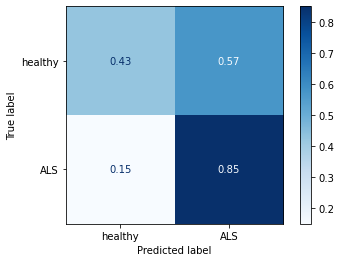



Modelo: Support Vector Machine
Conjunto de Treino

matriz de confusão = 
 [[ 3  3]
 [ 0 28]]
Sensibilidade =  1.0
Especificidade =  0.5
acc =  0.9117647058823529

Conjunto de Validação

matriz de confusão = 
 [[ 0  7]
 [ 0 19]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.7307692307692307

Conjunto de Teste

matriz de confusão = 
 [[ 0  7]
 [ 0 20]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.7407407407407407
Cross validation (100-Fold):
Score =  0.7572413793103447
Std =  0.07031777708430834


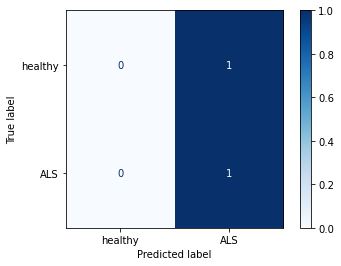



Modelo: Random Forests
Conjunto de Treino

matriz de confusão = 
 [[ 6  0]
 [ 0 28]]
Sensibilidade =  1.0
Especificidade =  1.0
acc =  1.0

Conjunto de Validação

matriz de confusão = 
 [[ 0  7]
 [ 0 19]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.7307692307692307

Conjunto de Teste

matriz de confusão = 
 [[ 0  7]
 [ 0 20]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.7407407407407407
Cross validation (100-Fold):
Score =  0.7527586206896554
Std =  0.07571380496047825


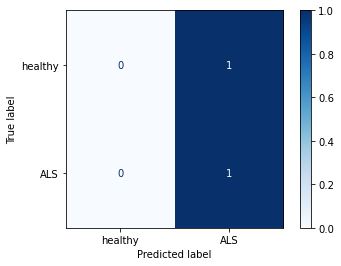

In [13]:
alsLrDtiResume = showResults(clfAlsLR, 'Logistic Regression', 
                             x, y, 
                             xTrain, xVal, xTest, 
                             yTrain, yVal, yTest, 
                             ['healthy', 'ALS'])

print('\n======================================================\n')

alsSvmDtiResume = showResults(clfAlsSVM, 'Support Vector Machine', 
                              x, y, 
                              xTrain, xVal, xTest, 
                              yTrain, yVal, yTest, 
                              ['healthy', 'ALS'])

print('\n======================================================\n')

alsRfDtiResume = showResults(clfAlsRF, 'Random Forests', 
                             x, y, 
                             xTrain, xVal, xTest, 
                             yTrain, yVal, yTest, 
                             ['healthy', 'ALS'])

---
#### Dados: Apenas Volumetria (T1)

Preparo dos dados e treino


**Modelos:** Regressão Logística, SVM, Random Forest

In [14]:
filteredData = t1Data

x, y, xTrain, yTrain, xVal, yVal, xTest, yTest = prepareData(filteredData, 'als', 0.1)

clfAlsLR = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', max_iter = 5000))
clfAlsSVM = make_pipeline(StandardScaler(), svm.SVC(gamma='auto', kernel='rbf'))
clfAlsRF = make_pipeline(StandardScaler(), RandomForestClassifier())

clfAlsLR.fit(xTrain, yTrain);
clfAlsSVM.fit(xTrain, yTrain);
clfAlsRF.fit(xTrain, yTrain);

Initial Dimensions:  (91, 173)
Post zeroVar:  (91, 29)


#### Results

Modelo: Logistic Regression
Conjunto de Treino

matriz de confusão = 
 [[ 4  2]
 [ 0 30]]
Sensibilidade =  1.0
Especificidade =  0.6666666666666666
acc =  0.9444444444444444

Conjunto de Validação

matriz de confusão = 
 [[ 2  9]
 [ 1 15]]
Sensibilidade =  0.9375
Especificidade =  0.18181818181818182
acc =  0.6296296296296297

Conjunto de Teste

matriz de confusão = 
 [[ 1  3]
 [ 4 20]]
Sensibilidade =  0.8333333333333334
Especificidade =  0.25
acc =  0.75
Cross validation (100-Fold):
Score =  0.7135483870967744
Std =  0.06488282883496582


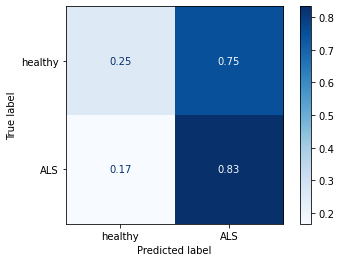



Modelo: Support Vector Machine
Conjunto de Treino

matriz de confusão = 
 [[ 0  6]
 [ 0 30]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.8333333333333334

Conjunto de Validação

matriz de confusão = 
 [[ 0 11]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.5925925925925926

Conjunto de Teste

matriz de confusão = 
 [[ 0  4]
 [ 0 24]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.8571428571428571
Cross validation (100-Fold):
Score =  0.765483870967742
Std =  0.05839600716183743


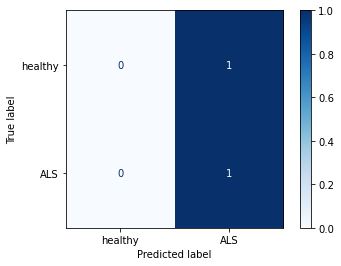



Modelo: Random Forests
Conjunto de Treino

matriz de confusão = 
 [[ 6  0]
 [ 0 30]]
Sensibilidade =  1.0
Especificidade =  1.0
acc =  1.0

Conjunto de Validação

matriz de confusão = 
 [[ 1 10]
 [ 0 16]]
Sensibilidade =  1.0
Especificidade =  0.09090909090909091
acc =  0.6296296296296297

Conjunto de Teste

matriz de confusão = 
 [[ 0  4]
 [ 0 24]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.8571428571428571
Cross validation (100-Fold):
Score =  0.7541935483870968
Std =  0.058204133219465985


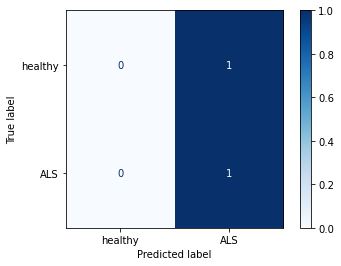

In [15]:
alsLrT1Resume = showResults(clfAlsLR, 'Logistic Regression', 
                            x, y, 
                            xTrain, xVal, xTest, 
                            yTrain, yVal, yTest, 
                            ['healthy', 'ALS'])

print('\n======================================================\n')

alsSvmT1Resume = showResults(clfAlsSVM, 'Support Vector Machine', 
                             x, y, 
                             xTrain, xVal, xTest, 
                             yTrain, yVal, yTest, 
                             ['healthy', 'ALS'])

print('\n======================================================\n')

alsRfT1Resume = showResults(clfAlsRF, 'Random Forests', 
                            x, y, 
                            xTrain, xVal, xTest, 
                            yTrain, yVal, yTest, 
                            ['healthy', 'ALS'])

---

#### Dados: Difusão (DTI) e Volumetria (T1)

Preparo dos dados e treino


**Modelos:** Regressão Logística, SVM, Random Forest

In [16]:
filteredData = allData

x, y, xTrain, yTrain, xVal, yVal, xTest, yTest = prepareData(filteredData, 'als', 0.1)

clfAlsLR = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', max_iter = 5000))
clfAlsSVM = make_pipeline(StandardScaler(), svm.SVC(gamma='auto', kernel='rbf'))
clfAlsRF = make_pipeline(StandardScaler(), RandomForestClassifier())

clfAlsLR.fit(xTrain, yTrain);
clfAlsSVM.fit(xTrain, yTrain);
clfAlsRF.fit(xTrain, yTrain);

Initial Dimensions:  (87, 959)
Post zeroVar:  (87, 187)


#### Results

Modelo: Logistic Regression
Conjunto de Treino

matriz de confusão = 
 [[ 6  0]
 [ 0 28]]
Sensibilidade =  1.0
Especificidade =  1.0
acc =  1.0

Conjunto de Validação

matriz de confusão = 
 [[ 3  4]
 [ 0 19]]
Sensibilidade =  1.0
Especificidade =  0.42857142857142855
acc =  0.8461538461538461

Conjunto de Teste

matriz de confusão = 
 [[ 2  5]
 [ 1 19]]
Sensibilidade =  0.95
Especificidade =  0.2857142857142857
acc =  0.7777777777777778
Cross validation (100-Fold):
Score =  0.840344827586207
Std =  0.0638918155194279


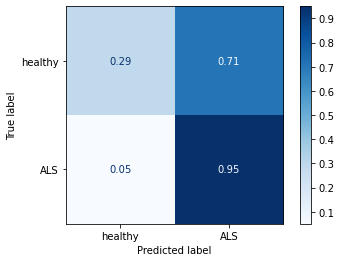



Modelo: Support Vector Machine
Conjunto de Treino

matriz de confusão = 
 [[ 4  2]
 [ 0 28]]
Sensibilidade =  1.0
Especificidade =  0.6666666666666666
acc =  0.9411764705882353

Conjunto de Validação

matriz de confusão = 
 [[ 0  7]
 [ 0 19]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.7307692307692307

Conjunto de Teste

matriz de confusão = 
 [[ 0  7]
 [ 0 20]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.7407407407407407
Cross validation (100-Fold):
Score =  0.7686206896551724
Std =  0.08047052473280443


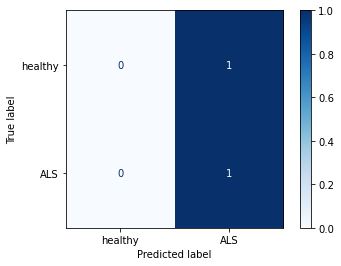



Modelo: Random Forests
Conjunto de Treino

matriz de confusão = 
 [[ 6  0]
 [ 0 28]]
Sensibilidade =  1.0
Especificidade =  1.0
acc =  1.0

Conjunto de Validação

matriz de confusão = 
 [[ 0  7]
 [ 0 19]]
Sensibilidade =  1.0
Especificidade =  0.0
acc =  0.7307692307692307

Conjunto de Teste

matriz de confusão = 
 [[ 0  7]
 [ 1 19]]
Sensibilidade =  0.95
Especificidade =  0.0
acc =  0.7037037037037037
Cross validation (100-Fold):
Score =  0.789655172413793
Std =  0.08325997563896301


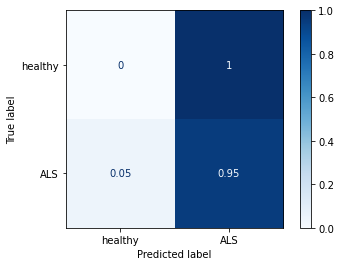

In [17]:
alsLrAllResume = showResults(clfAlsLR, 'Logistic Regression', 
                             x, y, 
                             xTrain, xVal, xTest, 
                             yTrain, yVal, yTest, 
                             ['healthy', 'ALS'])

print('\n======================================================\n')

alsSvmAllResume = showResults(clfAlsSVM, 'Support Vector Machine', 
                              x, y, 
                              xTrain, xVal, xTest, 
                              yTrain, yVal, yTest, 
                              ['healthy', 'ALS'])

print('\n======================================================\n')

alsRfAllResume = showResults(clfAlsRF, 'Random Forests', 
                             x, y, 
                             xTrain, xVal, xTest, 
                             yTrain, yVal, yTest, 
                             ['healthy', 'ALS'])

In [18]:
alsLrResults = [alsLrDtiResume, alsLrT1Resume, alsLrAllResume]
alsSvmResults = [alsSvmDtiResume, alsSvmT1Resume, alsSvmAllResume]
alsRfResults = [alsRfDtiResume, alsRfT1Resume, alsRfAllResume]
    
print('Table 3: Logistic Regression Results')
printResults(['dti', 't1', 'all'], alsLrResults)

print('=======================================================================================')

print('Table 4: SVM Results')
printResults(['dti', 't1', 'all'], alsSvmResults)

print('=======================================================================================')

print('Table 5: Random Forest Results')
printResults(['dti', 't1', 'all'], alsRfResults)

Table 3: Logistic Regression Results
data	crossValScore	crossValStd	testAcc		testSens	testSpec
dti	0.741724	0.070752	0.740741	0.850000	0.428571
t1	0.713548	0.064883	0.750000	0.833333	0.250000
all	0.840345	0.063892	0.777778	0.950000	0.285714
Table 4: SVM Results
data	crossValScore	crossValStd	testAcc		testSens	testSpec
dti	0.757241	0.070318	0.740741	1.000000	0.000000
t1	0.765484	0.058396	0.857143	1.000000	0.000000
all	0.768621	0.080471	0.740741	1.000000	0.000000
Table 5: Random Forest Results
data	crossValScore	crossValStd	testAcc		testSens	testSpec
dti	0.752759	0.075714	0.740741	1.000000	0.000000
t1	0.754194	0.058204	0.857143	1.000000	0.000000
all	0.789655	0.083260	0.703704	0.950000	0.000000


---

### Classificador: Esporadico/C9o/VAPB
#### Dados: Apenas Difusão (DTI)

Preparo dos dados e treino


**Modelos:** Random Forest

Nesse caso, existem três possibilidades de classificação: ELA esporádica, c9orf72 e VAPB, portanto não se pode utilizar os mesmos modelos antes, apenas o random forest, pois ele é capaz de gerar mais de dois *tags* como *output*.

In [19]:
filteredData = dtiData[dtiData['als'] == 1]
x, y, xTrain, yTrain, xVal, yVal, xTest, yTest = prepareData(filteredData, 'group', 0.1)

clfGroupRF = make_pipeline(StandardScaler(), RandomForestClassifier())

clfGroupRF.fit(xTrain, yTrain);

Initial Dimensions:  (67, 785)
Post zeroVar:  (67, 157)


#### Results

Modelo: Random Forests
Conjunto de Treino

matriz de confusão = 
 [[11  0  0]
 [ 0  5  0]
 [ 0  0 10]]
Sensibilidade =  0.45454545454545453
Especificidade =  inf
acc =  1.0

Conjunto de Validação

matriz de confusão = 
 [[5 1 1]
 [2 0 2]
 [6 0 3]]
Sensibilidade =  0.0
Especificidade =  inf
acc =  0.4

Conjunto de Teste

matriz de confusão = 
 [[8 2 1]
 [0 1 2]
 [3 1 3]]
Sensibilidade =  0.09090909090909091
Especificidade =  inf
acc =  0.5714285714285714
Cross validation (100-Fold):


<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity
<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity
<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity


Score =  0.5178260869565218
Std =  0.08588359819292231


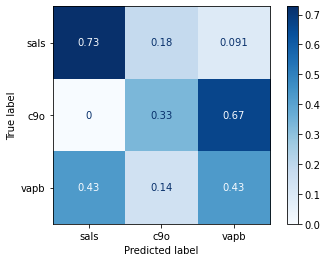

In [20]:
groupRfDtiResume = showResults(clfGroupRF, 'Random Forests', 
            x, y, 
            xTrain, xVal, xTest, 
            yTrain, yVal, yTest, 
            ['sals', 'c9o', 'vapb'])

---

#### Dados: Apenas Volumetria (T1)

Preparo dos dados e treino


**Modelos:** Random Forest

In [21]:
filteredData = t1Data[t1Data['als'] == 1]
x, y, xTrain, yTrain, xVal, yVal, xTest, yTest = prepareData(filteredData, 'group', 0.1)

clfGroupRF = make_pipeline(StandardScaler(), RandomForestClassifier())

clfGroupRF.fit(xTrain, yTrain);

Initial Dimensions:  (70, 173)
Post zeroVar:  (70, 28)


#### Results

Modelo: Random Forests
Conjunto de Treino

matriz de confusão = 
 [[11  0  0]
 [ 0  7  0]
 [ 0  0 10]]
Sensibilidade =  0.6363636363636364
Especificidade =  inf
acc =  1.0

Conjunto de Validação

matriz de confusão = 
 [[5 0 2]
 [3 0 1]
 [6 2 2]]
Sensibilidade =  0.0
Especificidade =  inf
acc =  0.3333333333333333

Conjunto de Teste

matriz de confusão = 
 [[7 4 1]
 [1 2 0]
 [5 0 1]]
Sensibilidade =  0.16666666666666666
Especificidade =  inf
acc =  0.47619047619047616
Cross validation (100-Fold):


<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity
<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity
<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity


Score =  0.4633333333333334
Std =  0.08922505876216116


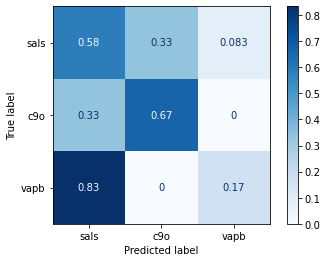

In [22]:
groupRfT1Resume = showResults(clfGroupRF, 'Random Forests', 
            x, y, 
            xTrain, xVal, xTest, 
            yTrain, yVal, yTest, 
            ['sals', 'c9o', 'vapb'])

---

#### Dados: Difusão (DTI) e Volumetria (T1)

**Preparo dos dados e treino**


**Modelos:** Random Forest

In [23]:
filteredData = allData[allData['als'] == 1]
x, y, xTrain, yTrain, xVal, yVal, xTest, yTest = prepareData(filteredData, 'group', 0.1)

clfGroupRF = make_pipeline(StandardScaler(), RandomForestClassifier())

clfGroupRF.fit(xTrain, yTrain);

Initial Dimensions:  (67, 959)
Post zeroVar:  (67, 186)


#### Results

Modelo: Random Forests
Conjunto de Treino

matriz de confusão = 
 [[11  0  0]
 [ 0  5  0]
 [ 0  0 10]]
Sensibilidade =  0.45454545454545453
Especificidade =  inf
acc =  1.0

Conjunto de Validação

matriz de confusão = 
 [[6 1 0]
 [2 0 2]
 [2 0 7]]
Sensibilidade =  0.0
Especificidade =  inf
acc =  0.65

Conjunto de Teste

matriz de confusão = 
 [[8 3 0]
 [1 2 0]
 [4 0 3]]
Sensibilidade =  0.18181818181818182
Especificidade =  inf
acc =  0.6190476190476191
Cross validation (100-Fold):


<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity
<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity
<ipython-input-11-eef98400c6cd>:40: RuntimeWarning: divide by zero encountered in longlong_scalars
  Spec = CM[0,0]/(y == 0).sum() # Calculate Specificity


Score =  0.6852173913043478
Std =  0.10254235143309867


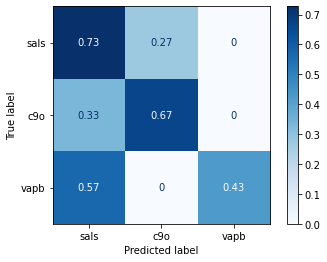

In [24]:
groupRfAllResume = showResults(clfGroupRF, 'Random Forests', 
            x, y, 
            xTrain, xVal, xTest, 
            yTrain, yVal, yTest, 
            ['sals', 'c9o', 'vapb'])

In [25]:
groupRfResults = [groupRfDtiResume, groupRfT1Resume, alsRfAllResume]

print('Table 6: Random Forest Results')
printResults(['dti', 't1', 'all'], groupRfResults)

Table 6: Random Forest Results
data	crossValScore	crossValStd	testAcc		testSens	testSpec
dti	0.517826	0.085884	0.571429	0.090909	inf
t1	0.463333	0.089225	0.476190	0.166667	inf
all	0.789655	0.083260	0.703704	0.950000	0.000000
